In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            validation_split = 0.2,
            # rotation_range = 30,
            # width_shift_range = 0.2,
            # height_shift_range = 0.2,
            # shear_range = 0.2,
            # zoom_range = 0.2,
            # fill_mode = 'nearest',
            )

train_gen = datagen.flow_from_directory(
    "Dataset/",
    target_size=(64, 64),
    color_mode = 'grayscale',
    seed = 42,
    batch_size=32,
    shuffle=True,
    subset='training',
    class_mode="input",
)

Found 162080 images belonging to 1 classes.


In [2]:
from tensorflow.keras import layers
def encoder():
    inputs = layers.Input(shape=(64, 64,1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation="relu")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x, name = "encoder")
    return model

def bottleneck():
    inputs = layers.Input(shape=(4,4,256))
    x = layers.Flatten()(inputs)
    x = layers.Dense(1024, activation="relu")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x,name = "bottleneck")
    return model

def decoder():
    inputs = layers.Input(shape=(1024,))
    x = layers.Dense(4 * 4 * 256, activation="relu")(inputs)
    x = layers.Reshape((4, 4, 256))(x)  
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x, name = "decoder")
    return model

In [3]:
model = tf.keras.models.Sequential([
    encoder(),
    bottleneck(),
    decoder()
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 4, 4, 256)         387840    
                                                                 
 bottleneck (Functional)     (None, 1024)              4195328   
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         4585985   
                                                                 
Total params: 9,169,153
Trainable params: 9,169,153
Non-trainable params: 0
_________________________________________________________________


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'best_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='max',
    save_best_only=True,
    verbose=0)

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss = tf.keras.losses.MeanSquaredError(),metrics = ['mse'])
model.fit(train_gen,steps_per_epoch = 50000//32,validation_steps=50000*0.2//32,epochs = 5,batch_size=32,callbacks = [checkpoint_callback])

Epoch 1/20
1562/1562 [==============================] - 1691s 1s/step - loss: 0.0110 - mse: 0.0110
Epoch 2/20
 656/1562 [===========>..................] - ETA: 16:58 - loss: 0.0103 - mse: 0.0103

KeyboardInterrupt: 

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("test.jpg",cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img,(64,64))
img = np.reshape(img,(1,64,64,1))
img = img/255
pred = model.predict(img)

1/1 [==============================] - 0s 35ms/step


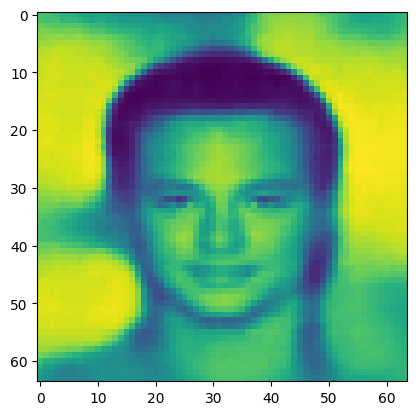

In [15]:
plt.imshow(pred[0])

In [ ]:
m